Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 12.8595 - task_10_accuracy: 0.6734 - task_11_accuracy: 0.7203 - task_1_accuracy: 0.6167 - task_2_accuracy: 0.6905 - task_3_accuracy: 0.7346 - task_4_accuracy: 0.5231 - task_5_accuracy: 0.7252 - task_6_accuracy: 0.5347 - task_7_accuracy: 0.6958 - task_8_accuracy: 0.7573 - task_9_accuracy: 0.5623 - val_loss: 10.8037 - val_task_10_accuracy: 0.7350 - val_task_11_accuracy: 0.7250 - val_task_1_accuracy: 0.6700 - val_task_2_accuracy: 0.7750 - val_task_3_accuracy: 0.8350 - val_task_4_accuracy: 0.7500 - val_task_5_accuracy: 0.7650 - val_task_6_accuracy: 0.7000 - val_task_7_accuracy: 0.7900 - val_task_8_accuracy: 0.7250 - val_task_9_accuracy: 0.6300
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.3488 - task_10_accuracy: 0.7182 - task_11_accuracy: 0.7618 - task_1_accuracy: 0.7292 - task_2_accuracy: 0.7893 - task_3_accuracy: 0.7628 - task_4_accuracy: 0.7914 - task_5_accuracy: 0.7615 - task_6_accuracy: 0.7554 - task_7_accura

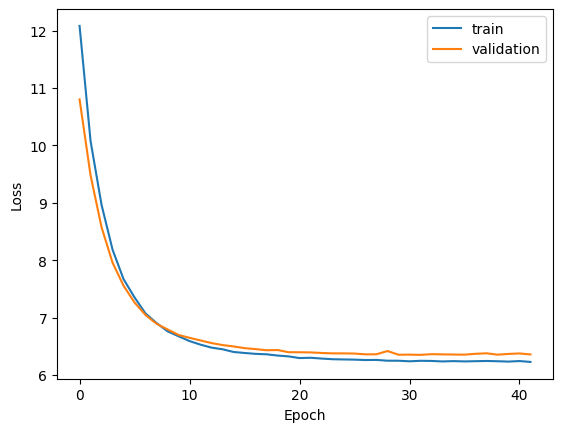

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Custom Regularizer
class SoftParameterSharingRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, strength, shared_weights):
        self.strength = strength
        self.shared_weights = shared_weights

    def __call__(self, x):
        penalty = 0
        for weight in self.shared_weights:
            penalty += tf.reduce_sum(tf.square(x - weight))
        return self.strength * penalty

# Custom Dense Layer
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, strength=0.01, **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.strength = strength
        self.regularizers = []

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(int(input_shape[-1]), self.units),
            initializer='glorot_uniform'
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer='zeros'
        )
        for reg in self.regularizers:
            self.add_loss(reg(self.kernel))
        super(CustomDense, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.kernel) + self.bias)

    def add_regularizer(self, reg):
        self.regularizers.append(reg)

# Load the data
X_train = np.load('X_train_normalized.npy')
y_train = np.load('y_train.npy')

# Define the shared input layer
inputs = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)

# Task-specific layers and outputs with soft parameter sharing
shared_kernels = []
outputs = []
for i in range(y_train.shape[1]):
    task_layer_1 = CustomDense(32)
    task_layer_2 = CustomDense(8)
    x1 = task_layer_1(x)
    x2 = task_layer_2(x1)

    if i == 0:
        shared_kernels.append(task_layer_1.kernel)
        shared_kernels.append(task_layer_2.kernel)
    else:
        task_layer_1.add_regularizer(SoftParameterSharingRegularizer(0.01, [shared_kernels[0]]))
        task_layer_2.add_regularizer(SoftParameterSharingRegularizer(0.01, [shared_kernels[1]]))

    output = Dense(1, activation='sigmoid', name=f'task_{i+1}')(x2)
    outputs.append(output)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=['binary_crossentropy']*y_train.shape[1],
              metrics=[['accuracy']]*y_train.shape[1])

# Prepare the targets as a list for fitting to the multi-output model
y_train_list = [y_train[:, i] for i in range(y_train.shape[1])]

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_list,
                    epochs=60,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Save the model
model.save('SoftParameterSharingModel.h5')

# Plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
# load the mode and make a prediction

model = tf.keras.models.load_model('HardParameter.h5')

X_test = np.load('X_test_normalized.npy')

y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        if y_pred[i][j] > 0.5:
            y_pred[i][j] = 1
        else:
            y_pred[i][j] = 0

print(y_pred)

# Save the predictions
np.save('y_pred.npy', y_pred)

ValueError: Input 0 of layer "functional_29" is incompatible with the layer: expected shape=(None, 97), found shape=(32, 106)